# Funnel Analytics: Signals for Revenue
### This notebook attempts to answer: what signals / metrics in the funnel are most indicative of close won revenue by building a logistic regression and testing with ROC

The Implementation is adapted from https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [94]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import normalize
import datetime
%matplotlib inline

In [123]:
df_load = pd.read_csv('0504_opp_progression.csv')

from `samsara-data.growth.oppty_progressions_all`
where cm__firstrespondeddate__c	 >= '2019-01-01'
and (close_lost_flag or won_flag)
;

In [124]:
df.describe()

,won_flag,features_interested,total_op_acv_amount,day_lead_to_opptie,day_lead_to_closewonorlost,max_stage_number,avg_day_in_stage,max_day_in_stage,day_to_stage_qualified,day_to_stage_Proposal,...,industry__c_Retail Trade,industry__c_Telephony & Wireless,industry__c_Transportation,industry__c_Transportation & Warehousing,industry__c_Transportation - Passenger Transit,industry__c_Unknown,industry__c_Utilities,industry__c_Waste Management,industry__c_Water & Water Treatment,industry__c_Wholesale Trade
count,21639.000000,21639.000000,2.163900e+04,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,...,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.00000
mean,0.297010,1.280096,1.097108e+04,7.651093,38.306160,3.251444,14.748223,30.655067,1.296918,4.878368,...,0.091317,0.000046,0.000092,0.238320,0.000323,0.168677,0.012709,0.000139,0.000046,0.01733
std,0.456952,1.494472,9.018797e+04,16.103108,46.508197,1.680107,21.489917,42.624838,12.479060,25.960029,...,0.288065,0.006798,0.009614,0.426065,0.017983,0.374475,0.112016,0.011774,0.006798,0.13050
min,0.000000,0.000000,1.670000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,1.591200e+03,0.000000,8.000000,2.000000,2.000000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,1.000000,2.995200e+03,1.000000,23.000000,3.000000,7.333333,16.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.000000,2.000000,7.020000e+03,6.000000,50.000000,4.000000,18.000000,40.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.000000,6.000000,8.745833e+06,91.000000,468.000000,32.000000,319.750000,454.000000,647.000000,844.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [125]:
df_load['respondeddate'] = df_load['cm__firstrespondeddate__c'].map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
df_load['year'] = df_load['respondeddate'].apply(lambda x: x.year)
df_load['month'] = df_load['respondeddate'].apply(lambda x: x.month)

In [126]:
df = df_load.drop(['cm__firstrespondeddate__c', 'respondeddate'],axis=1)

In [127]:
df = pd.get_dummies(df, prefix_sep='_', drop_first=True)

In [128]:
df.head(10)

,won_flag,features_interested,gps,eld,cameras,maintenance,routing,other,total_op_acv_amount,day_lead_to_opptie,...,industry__c_Retail Trade,industry__c_Telephony & Wireless,industry__c_Transportation,industry__c_Transportation & Warehousing,industry__c_Transportation - Passenger Transit,industry__c_Unknown,industry__c_Utilities,industry__c_Waste Management,industry__c_Water & Water Treatment,industry__c_Wholesale Trade
0,1,0,False,False,False,False,False,False,2150.4,1,...,0,0,0,1,0,0,0,0,0,0
1,0,0,False,False,False,False,False,False,1152.0,1,...,0,0,0,0,0,1,0,0,0,0
2,0,0,False,False,False,False,False,False,15062.0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,False,False,False,False,False,False,1404.0,8,...,0,0,0,0,0,1,0,0,0,0
4,0,0,False,False,False,False,False,False,1200.0,3,...,0,0,0,1,0,0,0,0,0,0
5,0,0,False,False,False,False,False,False,9360.0,89,...,0,0,0,0,0,0,0,0,0,0
6,0,0,False,False,False,False,False,False,2688.0,21,...,0,0,0,0,0,1,0,0,0,0
7,1,0,False,False,False,False,False,False,1296.0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,False,False,False,False,False,False,60948.0,1,...,0,0,0,1,0,0,0,0,0,0
9,0,0,False,False,False,False,False,False,14064.0,0,...,1,0,0,0,0,0,0,0,0,0


In [163]:
for x in df.columns:
    print("\'"+ x + "\',") 

'won_flag',
'features_interested',
'gps',
'eld',
'cameras',
'maintenance',
'routing',
'other',
'total_op_acv_amount',
'day_lead_to_opptie',
'day_lead_to_closewonorlost',
'max_stage_number',
'avg_day_in_stage',
'max_day_in_stage',
'qualified',
'day_to_stage_qualified',
'Proposal',
'day_to_stage_Proposal',
'Trial',
'day_to_stage_Trial',
'Purchase',
'day_to_stage_Purchase',
'Decision',
'day_to_stage_Decision',
'year',
'month',
'acv_bucket_b_2k',
'acv_bucket_c_4k',
'acv_bucket_d_12k',
'acv_bucket_e_>12k',
'billingcountry_United States',
'transformed_parent_campaign_Facebook',
'transformed_parent_campaign_Google Ads',
'transformed_parent_campaign_Linkedin',
'transformed_parent_campaign_MVF',
'transformed_parent_campaign_Other Lead Gen',
'transformed_parent_campaign_Website',
'fleet_size_3 - 50',
'fleet_size_50+',
'industry__c_Automotive Dealership',
'industry__c_Commercial & Residential Construction',
'industry__c_Construction',
'industry__c_Consumer Products',
'industry__c_Educational Serv

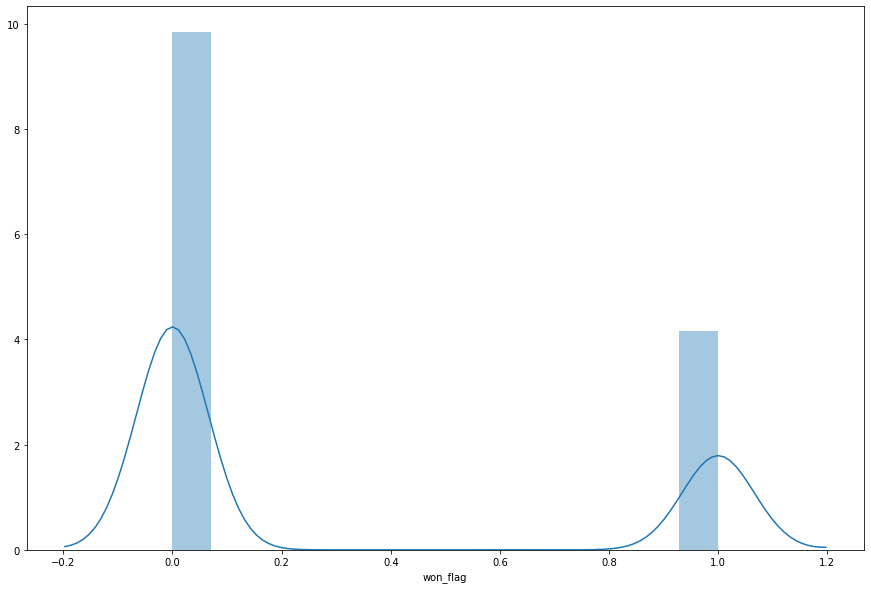

In [130]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(df['won_flag'])

In [131]:
df = df.fillna(0)

In [139]:
X = df.loc[:, df.columns != 'won_flag']
y = df.loc[:, df.columns == 'won_flag']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['won_flag'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['won_flag']==0]))
print("Number of subscription",len(os_data_y[os_data_y['won_flag']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['won_flag']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['won_flag']==1])/len(os_data_X))

length of oversampled data is  21364
Number of no subscription in oversampled data 10682
Number of subscription 10682
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [143]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=10000)
rfe = RFE(logreg, 20)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False  True  True
 False  True False  True False  True False  True False  True False False
 False False False  True  True False False False  True  True  True  True
 False  True False False False  True  True False False False False False
 False False False False False False False False False  True False False
 False False  True False False False False False False  True False False
 False  True]
[ 7  6 28 29 30  5 12 52 19 20  1  1  2  1 14  1 26  1 38  1 33  1 36 43
 40  4  3  1  1 39 17 34  1  1  1  1 41  1 53 54 16  1  1 24 51 42 25 49
 10 55 23  9 47 32 50 37 44  1 18 21 22 31  1 46 15 48 27 13  8  1 11 35
 45  1]


In [144]:
ref_cols = []
for x, y in zip(X.columns, rfe.support_):
    ref_cols.append(x) if y else ''

In [145]:
ref_cols

['max_stage_number',
 'avg_day_in_stage',
 'qualified',
 'Proposal',
 'Trial',
 'Purchase',
 'Decision',
 'acv_bucket_d_12k',
 'acv_bucket_e_>12k',
 'transformed_parent_campaign_Linkedin',
 'transformed_parent_campaign_MVF',
 'transformed_parent_campaign_Other Lead Gen',
 'transformed_parent_campaign_Website',
 'fleet_size_50+',
 'industry__c_Consumer Products',
 'industry__c_Educational Services',
 'industry__c_Movers',
 'industry__c_Professional Services',
 'industry__c_Unknown',
 'industry__c_Wholesale Trade']

In [146]:
X_reg=os_data_X[ref_cols]
y=os_data_y['won_flag']

In [150]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X_reg.astype(float))
result=logit_model.fit(maxiter=10000)
print(result.summary2())

         Current function value: 0.322911
         Iterations: 10000
                                            Results: Logit
Model:                            Logit                        Pseudo R-squared:             0.534     
Dependent Variable:               won_flag                     AIC:                          13837.3553
Date:                             2020-05-04 20:52             BIC:                          13996.7445
No. Observations:                 21364                        Log-Likelihood:               -6898.7   
Df Model:                         19                           LL-Null:                      -14808.   
Df Residuals:                     21344                        LLR p-value:                  0.0000    
Converged:                        0.0000                       Scale:                        1.0000    
No. Iterations:                   10000.0000                                                           
----------------------------------------

/opt/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [158]:
rfe_cols_reduced = [col for col in ref_cols if col not in ['other','industry__c_Movers','industry__c_Professional Services','industry__c_Wholesale Trade','transformed_parent_campaign_Linkedin', 'industry__c_Consumer Products'] ]
X=os_data_X[rfe_cols_reduced]
y=os_data_y['won_flag']
logit_model=sm.Logit(y,X.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.323195
         Iterations 8
                                      Results: Logit
Model:                        Logit                    Pseudo R-squared:         0.534     
Dependent Variable:           won_flag                 AIC:                      13839.4612
Date:                         2020-05-04 21:24         BIC:                      13959.0031
No. Observations:             21364                    Log-Likelihood:           -6904.7   
Df Model:                     14                       LL-Null:                  -14808.   
Df Residuals:                 21349                    LLR p-value:              0.0000    
Converged:                    1.0000                   Scale:                    1.0000    
No. Iterations:               8.0000                                                       
-------------------------------------------------------------------------------------------
                 

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression(max_iter = 5000)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [155]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


In [156]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[2808  357]
 [ 261 2984]]


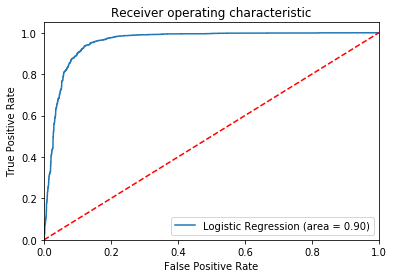

In [157]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [164]:
corrMatrix = df[['won_flag',
'features_interested',
'gps',
'eld',
'cameras',
'maintenance',
'routing',
'other',
'total_op_acv_amount',
'day_lead_to_opptie',
'day_lead_to_closewonorlost',
'max_stage_number',
'avg_day_in_stage',
'max_day_in_stage',
'qualified',
'day_to_stage_qualified',
'Proposal',
'day_to_stage_Proposal',
'Trial',
'day_to_stage_Trial',
'Purchase',
'day_to_stage_Purchase',
'Decision',
'day_to_stage_Decision',
'year',
'month',
'acv_bucket_b_2k',
'acv_bucket_c_4k',
'acv_bucket_d_12k',
'acv_bucket_e_>12k',
'billingcountry_United States',
'transformed_parent_campaign_Facebook',
'transformed_parent_campaign_Google Ads',
'transformed_parent_campaign_Linkedin',
'transformed_parent_campaign_MVF',
'transformed_parent_campaign_Other Lead Gen',
'transformed_parent_campaign_Website',
'fleet_size_3 - 50',
'fleet_size_50+']].corr()

In [165]:
print(corrMatrix)

                                            won_flag  features_interested  \
won_flag                                    1.000000             0.121125   
features_interested                         0.121125             1.000000   
gps                                         0.092956             0.754450   
eld                                         0.121508             0.655431   
cameras                                     0.087238             0.622330   
maintenance                                 0.067881             0.719730   
routing                                     0.052267             0.710688   
other                                       0.024519             0.340835   
total_op_acv_amount                        -0.035485             0.004146   
day_lead_to_opptie                          0.059110             0.006677   
day_lead_to_closewonorlost                 -0.180341            -0.031656   
max_stage_number                            0.553511             0.065893   

In [166]:
corrMatrix.to_csv('correlationmatrix.csv')